In [1]:
# Import required libraries
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import numpy as np
import requests
import zipfile
import os
from pathlib import Path

# Set up plotting parameters
plt.rcParams["figure.figsize"] = (15, 12)
plt.rcParams["font.size"] = 10

In [2]:
def download_and_load_data():
    """
    Download, extract, and load Brazilian states and biomes shapefiles.
    """
    data_dir = Path("maps_data")
    data_dir.mkdir(exist_ok=True)

    # URLs for the data
    states_url = "https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2022/Brasil/BR/BR_Regioes_2022.zip"
    biomes_url = "https://geoftp.ibge.gov.br/informacoes_ambientais/estudos_ambientais/biomas/vetores/Biomas_250mil.zip"

    states_zip = data_dir / "BR_Regioes_2022.zip"
    biomes_zip = data_dir / "Biomas_250mil.zip"

    states_shp = data_dir / "BR_Regioes_2022" / "BR_Regioes_2022.shp"
    biomes_shp = data_dir / "Biomas_250mil" / "lm_bioma_250.shp"

    # Download and extract states
    if not states_shp.exists():
        print("Downloading and extracting states data...")
        if not states_zip.exists():
            response = requests.get(states_url)
            response.raise_for_status()
            with open(states_zip, "wb") as f:
                f.write(response.content)
        with zipfile.ZipFile(states_zip, "r") as zip_ref:
            zip_ref.extractall(data_dir / "BR_Regioes_2022")

    # Download and extract biomes
    if not biomes_shp.exists():
        print("Downloading and extracting biomes data...")
        if not biomes_zip.exists():
            response = requests.get(biomes_url)
            response.raise_for_status()
            with open(biomes_zip, "wb") as f:
                f.write(response.content)
        with zipfile.ZipFile(biomes_zip, "r") as zip_ref:
            zip_ref.extractall(data_dir / "Biomas_250mil")

    # Load shapefiles
    print("Loading shapefiles...")
    states_gdf = gpd.read_file(states_shp)
    biomes_gdf = gpd.read_file(biomes_shp)

    return states_gdf, biomes_gdf

In [3]:
def create_brazil_map_with_biomes(states_gdf, biomes_gdf):
    """Create a vector map of Brazil showing administrative regions with biome colors"""

    # Ensure CRS match
    states_gdf = states_gdf.to_crs(biomes_gdf.crs)

    # Spatially join states and biomes
    brazil_biomes_gdf = gpd.overlay(states_gdf, biomes_gdf, how="intersection")

    # Define biome colors (in Portuguese for matching with data)
    biome_colors = {
        "Amazônia": "#228B22",  # Forest Green
        "Cerrado": "#DAA520",  # Goldenrod
        "Mata Atlântica": "#006400",  # Dark Green
        "Caatinga": "#D2691E",  # Chocolate
        "Pampa": "#9ACD32",  # Yellow Green
        "Pantanal": "#4682B4",  # Steel Blue
    }

    # English labels for the legend
    biome_labels_en = {
        "Amazônia": "Amazon",
        "Cerrado": "Cerrado",
        "Mata Atlântica": "Atlantic Forest",
        "Caatinga": "Caatinga",
        "Pampa": "Pampa",
        "Pantanal": "Pantanal",
    }

    # Create map figure
    fig, ax = plt.subplots(1, 1, figsize=(15, 12))

    # Plot biomes
    for biome_name_pt, color in biome_colors.items():
        # Filter for the current biome
        biome_gdf = brazil_biomes_gdf[brazil_biomes_gdf["Bioma"] == biome_name_pt]
        if not biome_gdf.empty:
            biome_gdf.plot(ax=ax, color=color, label=biome_labels_en[biome_name_pt], alpha=0.7)

    # Plot state boundaries
    states_gdf.boundary.plot(ax=ax, linewidth=1, edgecolor="black")

    # Set map properties
    ax.set_title(
        "Map of Brazilian Biomes by Administrative Regions",
        fontsize=16,
        fontweight="bold",
        pad=20,
    )
    ax.axis("off")

    # Create legend
    legend_elements = [mpatches.Patch(color=clr, label=biome_labels_en[bg]) for bg, clr in biome_colors.items()]
    ax.legend(handles=legend_elements, loc="upper right", title="Biomes")

    plt.tight_layout()
    return fig, ax

Creating Brazil map with administrative regions and biome colors...
Loading shapefiles...


/home/jacob/.cache/pypoetry/virtualenvs/paper-bionut-VUXlxHLR-py3.12/lib/python3.12/site-packages/geopandas/tools/overlay.py:358: UserWarning: `keep_geom_type=True` in overlay resulted in 63 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)


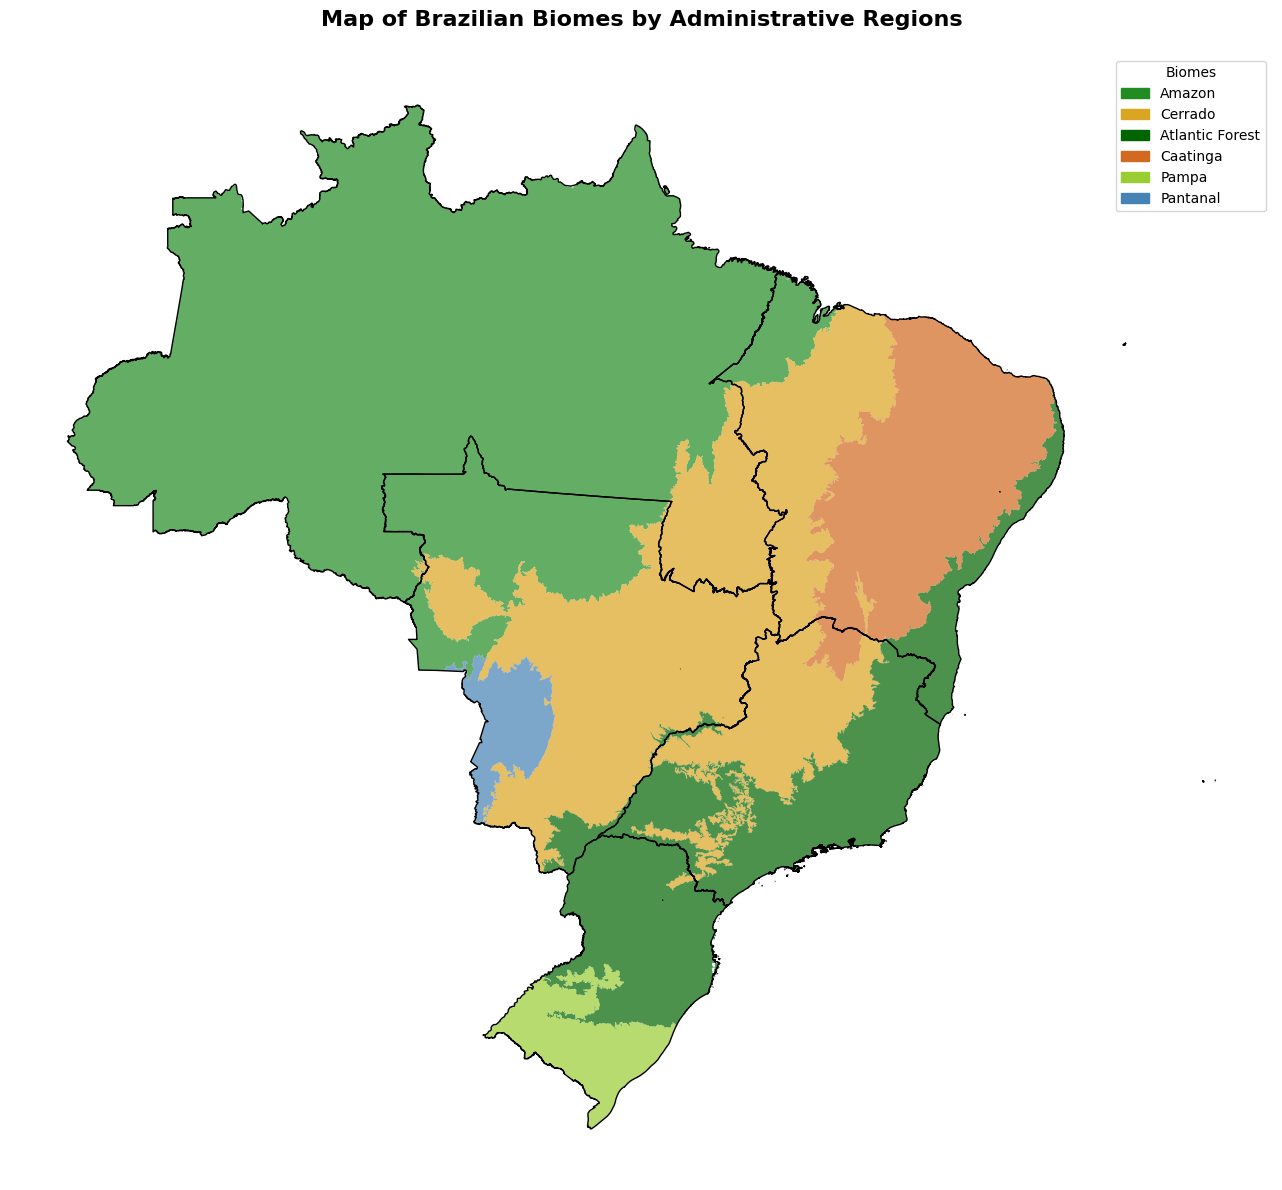

Map saved as PNG and SVG in output directory:
  - maps_output/brazil_map_regions_biomes.png
  - maps_output/brazil_map_regions_biomes.svg


In [4]:
# Execute the map creation
print("Creating Brazil map with administrative regions and biome colors...")

try:
    # Load the data
    states_gdf, biomes_gdf = download_and_load_data()

    # Create the map
    fig, ax = create_brazil_map_with_biomes(states_gdf, biomes_gdf)

    if fig is not None:
        plt.show()

        # Save the map
        output_dir = Path("maps_output")
        output_dir.mkdir(exist_ok=True)
        save_path_png = output_dir / "brazil_map_regions_biomes.png"
        save_path_svg = output_dir / "brazil_map_regions_biomes.svg"
        fig.savefig(save_path_png, dpi=300, bbox_inches="tight")
        fig.savefig(save_path_svg, format="svg", bbox_inches="tight")
        print(f"Map saved as PNG and SVG in output directory:")
        print(f"  - {save_path_png}")
        print(f"  - {save_path_svg}")
    else:
        print("Failed to create map")

except Exception as e:
    print(f"An error occurred: {e}")